In [1]:
########## 1. Import required libraries ##########

import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
import xgboost as xgb
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_curve, auc, log_loss,classification_report, confusion_matrix)

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
########## 2. Define text preprocessing methods ##########

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

NLTK_stop_words_list = stopwords.words('english')
custom_stop_words_list = ['...']  # Add your own domain stopwords if needed
final_stop_words_list = NLTK_stop_words_list + custom_stop_words_list

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in final_stop_words_list])

def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),.!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()


In [3]:
########## 3. Read and clean data ##########

project = 'tensorflow'  # You can change to 'tensorflow', etc.
path = f'{project}.csv'


df = pd.read_csv(path)
df = df.sample(frac=1, random_state=999)
print("Dataset Name:",path,"\nDataset Size:",df.shape)

df.columns = df.columns.str.strip()
df = df.dropna(subset=["Title", "Body", "class"])

# Merge Title and Body
df['text'] = df.apply(
    lambda row: row['Title'] + '. ' + row['Body'] if pd.notna(row['Body']) else row['Title'],
    axis=1
)

df = df.rename(columns={"class": "sentiment"})
df = df[["text", "sentiment"]]

# Clean the text
df['text'] = df['text'].apply(remove_html)
df['text'] = df['text'].apply(remove_emoji)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(clean_str)

df.head()


Dataset Name: tensorflow.csv 
Dataset Size: (1490, 12)


,text,sentiment
1465,tensorflow installation error. tensorflow inst...,0
406,no module named tensorflow i import tensorflow...,0
1474,failed load native tensorflow runtime.. c user...,0
477,raise undefined symbol tensorflow.contrib.fuse...,0
1449,saving optimizer state (adagrad momentum etc. ...,0


In [4]:
########## 4. Configure parameters & Start training for Naive Bayes##########


# Number of repeated experiments
REPEAT = 10

# Output CSV file name
out_csv_name = f'{project}_NB.csv'


text_col = 'text'



# ========== Hyperparameter grid ==========
# We use logspace for var_smoothing: [1e-12, 1e-11, ..., 1]
params = {
    'var_smoothing': np.logspace(-12, 0, 13)
}

# Lists to store metrics across repeated runs
accuracies  = []
lossess     = []
precisions  = []
recalls     = []
f1_scores   = []
auc_values  = []

for repeated_time in range(REPEAT):
    # --- 4.1 Split into train/test ---
    indices = np.arange(df.shape[0])
    train_index, test_index = train_test_split(
        indices, test_size=0.2, random_state=repeated_time
    )

    train_text = df[text_col].iloc[train_index]
    test_text = df[text_col].iloc[test_index]

    y_train = df['sentiment'].iloc[train_index]
    y_test  = df['sentiment'].iloc[test_index]

    # --- 4.2 TF-IDF vectorization ---
    tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=1000  # Adjust as needed
    )
    X_train = tfidf.fit_transform(train_text)
    X_test = tfidf.transform(test_text)

    # --- 4.3 Naive Bayes model & GridSearch ---
    clf = GaussianNB()
    grid = GridSearchCV(
        clf,
        params,
        cv=5,              # 5-fold CV (can be changed)
        scoring='roc_auc'  # Using roc_auc as the metric for selection
    )
    grid.fit(X_train.toarray(), y_train)

    # Retrieve the best model
    best_clf = grid.best_estimator_
    best_clf.fit(X_train.toarray(), y_train)

    # --- 4.4 Make predictions & evaluate ---
    y_pred = best_clf.predict(X_test.toarray())

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # loss
    y_proba = best_clf.predict_proba(X_test.toarray())  # Needed for log loss
    # Log Loss
    loss = log_loss(y_test, y_proba)
    lossess.append(loss)

    # Precision (macro)
    prec = precision_score(y_test, y_pred, average='macro')
    precisions.append(prec)

    # Recall (macro)
    rec = recall_score(y_test, y_pred, average='macro')
    recalls.append(rec)

    # F1 Score (macro)
    f1 = f1_score(y_test, y_pred, average='macro')
    f1_scores.append(f1)

    # AUC
    # If labels are 0/1 only, this works directly.
    # If labels are something else, adjust pos_label accordingly.
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_val = auc(fpr, tpr)

    auc_values.append(auc_val)

In [5]:
########## 5. Aggregate results for  Navie Bayes ##########
nb_f1_list=  f1_scores.copy()

final_accuracy  = np.mean(accuracies)
final_loss = np.mean(lossess)
final_precision = np.mean(precisions)
final_recall    = np.mean(recalls)
final_f1        = np.mean(f1_scores)
final_auc       = np.mean(auc_values)

print("=== Naive Bayes + TF-IDF Results ===")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy:.4f}")
print(f"Average Precision:     {final_precision:.4f}")
print(f"Average Recall:        {final_recall:.4f}")
print(f"Average F1 score:      {final_f1:.4f}")
print(f"Average AUC:           {final_auc:.4f}")
print(f"Average Log Loss:      {final_loss:.4f}")

# Save final results to CSV (append mode)
try:
    # Attempt to check if the file already has a header
    existing_data = pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log = pd.DataFrame(
    {
        'repeated_times': [REPEAT],
        'Accuracy': [final_accuracy],
        'Precision': [final_precision],
        'Recall': [final_recall],
        'F1': [final_f1],
        'AUC': [final_auc],
        'CV_list(AUC)': [str(auc_values)]
    }
)

df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)

print(f"\nResults have been saved to: {out_csv_name}")


=== Naive Bayes + TF-IDF Results ===
Number of repeats:     10
Average Accuracy:      0.5620
Average Precision:     0.6350
Average Recall:        0.7151
Average F1 score:      0.5402
Average AUC:           0.7151
Average Log Loss:      2.2260

Results have been saved to: tensorflow_NB.csv



Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0     0.9727    0.4332    0.5994       247
           1     0.2513    0.9400    0.3966        50

    accuracy                         0.5185       297
   macro avg     0.6120    0.6866    0.4980       297
weighted avg     0.8513    0.5185    0.5653       297



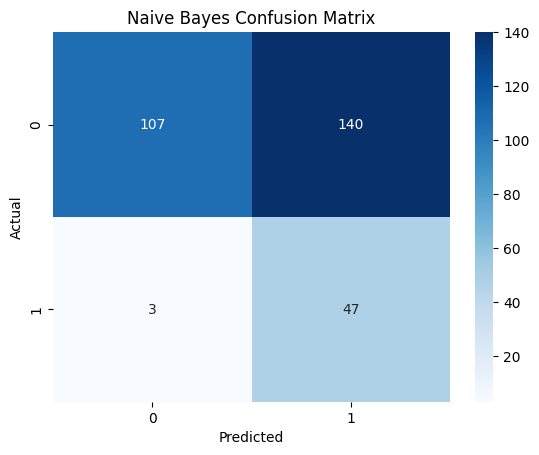

In [6]:
########## 6. Confusion Matrix for Naive Bayes ##########

print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [7]:
########## 4. Train SVM model & Evaluate ##########

REPEAT = 10
out_csv_name = f"{project}_SVM.csv"

accuracies, lossess, precisions, recalls, f1_scores, auc_values = [], [], [], [], [], []

for seed in range(REPEAT):
    train_index, test_index = train_test_split(df.index, test_size=0.2, random_state=seed)

    X_train = df.loc[train_index, "text"]
    X_test = df.loc[test_index, "text"]
    y_train = df.loc[train_index, "sentiment"]
    y_test = df.loc[test_index, "sentiment"]

    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_vec = tfidf.fit_transform(X_train)
    X_test_vec = tfidf.transform(X_test)

    # SVM with probability calibration for log loss
    base_svm = LinearSVC()
    clf = CalibratedClassifierCV(base_svm)
    clf.fit(X_train_vec, y_train)

    y_pred = clf.predict(X_test_vec)
    y_proba = clf.predict_proba(X_test_vec)

    accuracies.append(accuracy_score(y_test, y_pred))
    lossess.append(log_loss(y_test, y_proba))
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_values.append(auc(fpr, tpr))

In [8]:
########## 5. Aggregate results for SVM ##########

svm_f1_list = f1_scores.copy()

final_accuracy  = np.mean(accuracies)
final_loss      = np.mean(lossess)
final_precision = np.mean(precisions)
final_recall    = np.mean(recalls)
final_f1        = np.mean(f1_scores)
final_auc       = np.mean(auc_values)

print("=== SVM + TF-IDF Results ===")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy:.4f}")
print(f"Average Precision:     {final_precision:.4f}")
print(f"Average Recall:        {final_recall:.4f}")
print(f"Average F1 score:      {final_f1:.4f}")
print(f"Average AUC:           {final_auc:.4f}")
print(f"Average Log Loss:      {final_loss:.4f}")

# Save to CSV
df_log = pd.DataFrame({
    'repeated_times': [REPEAT],
    'Accuracy': [final_accuracy],
    'Precision': [final_precision],
    'Recall': [final_recall],
    'F1': [final_f1],
    'AUC': [final_auc],
    'CV_list(AUC)': [str(auc_values)]
})

try:
    pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)

print(f"\nResults have been saved to: {out_csv_name}")


=== SVM + TF-IDF Results ===
Number of repeats:     10
Average Accuracy:      0.8923
Average Precision:     0.8499
Average Recall:        0.7649
Average F1 score:      0.7959
Average AUC:           0.7649
Average Log Loss:      0.2628

Results have been saved to: tensorflow_SVM.csv


SVM Classification Report:
              precision    recall  f1-score   support

           0     0.9112    0.9555    0.9328       247
           1     0.7105    0.5400    0.6136        50

    accuracy                         0.8855       297
   macro avg     0.8109    0.7477    0.7732       297
weighted avg     0.8774    0.8855    0.8791       297



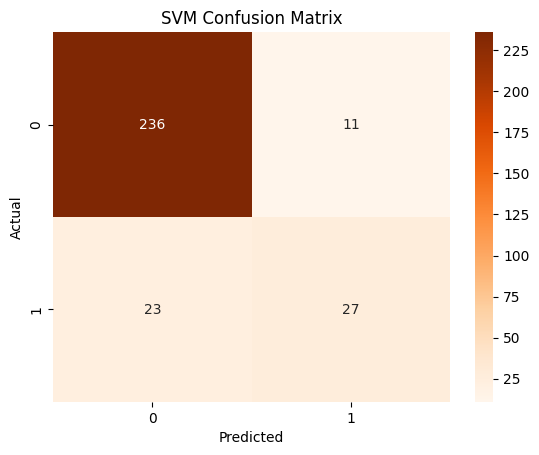

In [9]:
########## 6. Confusion Matrix for SVM ##########
print("SVM Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
########## 4. Train XGBoost model & Evaluate ##########

REPEAT = 10
out_csv_name = f"{project}_XGBoost.csv"

accuracies, lossess, precisions, recalls, f1_scores, auc_values = [], [], [], [], [], []

for seed in range(REPEAT):
    train_index, test_index = train_test_split(df.index, test_size=0.2, random_state=seed)

    X_train = df.loc[train_index, "text"]
    X_test = df.loc[test_index, "text"]
    y_train = df.loc[train_index, "sentiment"]
    y_test = df.loc[test_index, "sentiment"]

    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
    X_train_vec = tfidf.fit_transform(X_train)
    X_test_vec = tfidf.transform(X_test)

    # --- 4.3 XGBoost model & hyperparameters ---
    clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        max_depth=6,
        n_estimators=100,
        learning_rate=0.1,
        verbosity=0
    )
    clf.fit(X_train_vec, y_train)

    y_pred = clf.predict(X_test_vec)
    y_proba = clf.predict_proba(X_test_vec)

    accuracies.append(accuracy_score(y_test, y_pred))
    lossess.append(log_loss(y_test, y_proba))
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_values.append(auc(fpr, tpr))

In [11]:
########## 5. Aggregate results for XGBoost ##########

XGBoost_f1_list = f1_scores.copy()

final_accuracy  = np.mean(accuracies)
final_loss      = np.mean(lossess)
final_precision = np.mean(precisions)
final_recall    = np.mean(recalls)
final_f1        = np.mean(f1_scores)
final_auc       = np.mean(auc_values)

print("=== XG + TF-IDF Results ===")
print(f"Number of repeats:     {REPEAT}")
print(f"Average Accuracy:      {final_accuracy:.4f}")
print(f"Average Precision:     {final_precision:.4f}")
print(f"Average Recall:        {final_recall:.4f}")
print(f"Average F1 score:      {final_f1:.4f}")
print(f"Average AUC:           {final_auc:.4f}")
print(f"Average Log Loss:      {final_loss:.4f}")

# Save to CSV
df_log = pd.DataFrame({
    'repeated_times': [REPEAT],
    'Accuracy': [final_accuracy],
    'Precision': [final_precision],
    'Recall': [final_recall],
    'F1': [final_f1],
    'AUC': [final_auc],
    'CV_list(AUC)': [str(auc_values)]
})

try:
    pd.read_csv(out_csv_name, nrows=1)
    header_needed = False
except:
    header_needed = True

df_log.to_csv(out_csv_name, mode='a', header=header_needed, index=False)

print(f"\nResults have been saved to: {out_csv_name}")


=== XG + TF-IDF Results ===
Number of repeats:     10
Average Accuracy:      0.8970
Average Precision:     0.8490
Average Recall:        0.7880
Average F1 score:      0.8120
Average AUC:           0.7880
Average Log Loss:      0.2617

Results have been saved to: tensorflow_XGBoost.csv


XG Boost Classification Report:
              precision    recall  f1-score   support

           0     0.9066    0.9433    0.9246       247
           1     0.6500    0.5200    0.5778        50

    accuracy                         0.8721       297
   macro avg     0.7783    0.7317    0.7512       297
weighted avg     0.8634    0.8721    0.8662       297



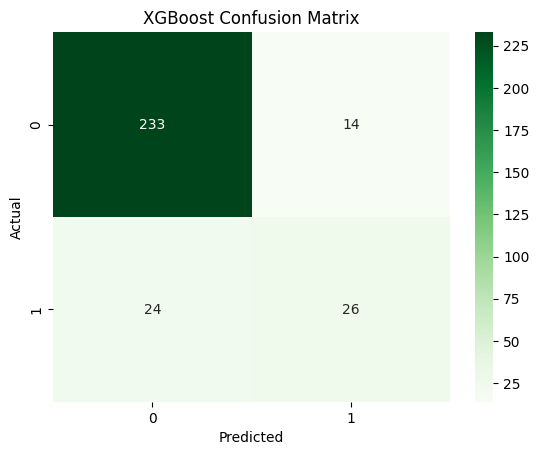

In [12]:
########## 6. Confusion Matrix for XGBoost ##########
print("XG Boost Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
svm_results = pd.read_csv(f'{project}_SVM.csv')
nb_results = pd.read_csv(f'{project}_NB.csv')
xgboost_results = pd.read_csv(f'{project}_XGBoost.csv')
distilBERT_results = pd.read_csv(f'{project}_BERT.csv')

In [17]:
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "AUC", "Log Loss"],
    "Naive Bayes": [
        nb_results["Accuracy"].values[0],
        nb_results["Precision"].values[0],
        nb_results["Recall"].values[0],
        nb_results["F1"].values[0],
        nb_results["AUC"].values[0],
        nb_results["CV_list(AUC)"].values[0]  # if Log Loss stored here instead, fix key
    ],
    "SVM": [
        svm_results["Accuracy"].values[0],
        svm_results["Precision"].values[0],
        svm_results["Recall"].values[0],
        svm_results["F1"].values[0],
        svm_results["AUC"].values[0],
        svm_results["CV_list(AUC)"].values[0]  # if Log Loss stored here instead, fix key
    ],
    "XGBoost": [
        xgboost_results["Accuracy"].values[0],
        xgboost_results["Precision"].values[0],
        xgboost_results["Recall"].values[0],
        xgboost_results["F1"].values[0],
        xgboost_results["AUC"].values[0],
        xgboost_results["CV_list(AUC)"].values[0]  # if Log Loss stored here instead, fix key
    ],
    "distilBERT": [
        distilBERT_results["Accuracy"].values[0],
        distilBERT_results["Precision"].values[0],
        distilBERT_results["Recall"].values[0],
        distilBERT_results["F1"].values[0],
        distilBERT_results["AUC"].values[0],
        distilBERT_results["CV_list(AUC)"].values[0]  # if Log Loss stored here instead, fix key
    ]
})
comparison


,Metric,Naive Bayes,SVM,XGBoost,distilBERT
0,Accuracy,0.561953,0.892256,0.89697,0.859504
1,Precision,0.635041,0.849867,0.848972,0.882158
2,Recall,0.715062,0.764907,0.788027,0.829827
3,F1,0.540218,0.795902,0.811973,0.855176
4,AUC,0.715062,0.764907,0.788027,0.936207
5,Log Loss,"[np.float64(0.7200851063829787), np.float64(0....","[np.float64(0.7326808510638296), np.float64(0....","[np.float64(0.7945106382978724), np.float64(0....","[np.float64(0.9506522778498736), np.float64(0...."


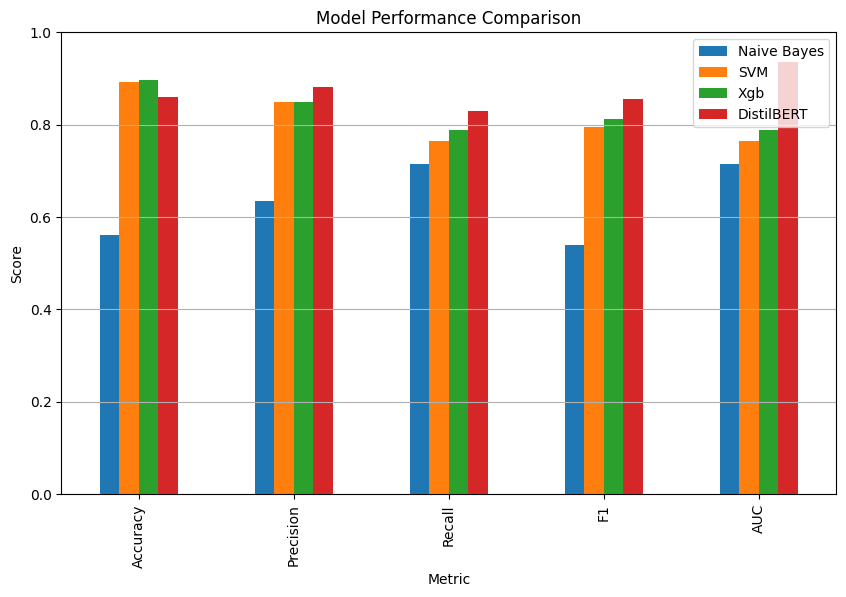

In [18]:
metrics = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
nb_vals = [nb_results[m].values[0] for m in metrics]
svm_vals = [svm_results[m].values[0] for m in metrics]
xgboost_vals = [xgboost_results[m].values[0] for m in metrics]
distilBERT_vals = [distilBERT_results[m].values[0] for m in metrics]

df_bar = pd.DataFrame({
    "Metric": metrics,
    "Naive Bayes": nb_vals,
    "SVM": svm_vals,
    "Xgb": xgboost_vals,
    "DistilBERT": distilBERT_vals
})

df_bar.set_index("Metric").plot(kind="bar", figsize=(10, 6), title="Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()
